# Segmentaion with Distance Transform and Watershed Algorithm

Tutorial taken from here: https://www.ccoderun.ca/programming/doxygen/opencv/tutorial_distance_transform.html

In [15]:
import cv2 as cv
import numpy as np
import argparse
import random as rng
import matplotlib.pyplot as plt
rng.seed(12345)

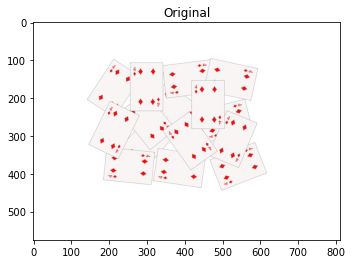

In [35]:
src = cv.imread('./img/watershed_segmentation_demo_01.jpg')
src = cv.cvtColor(src, cv.COLOR_BGR2RGB)
plt.imshow(src); plt.title('Original')
plt.show()

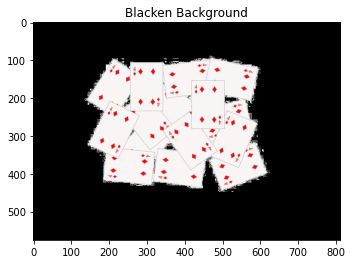

In [36]:
# Change the background from white to black, since that will help later to extract
# better results during the use of Distance Transform
src[np.all(src == 255, axis=2)] = 0
# Show output image
plt.imshow(src); plt.title('Blacken Background')
plt.show()

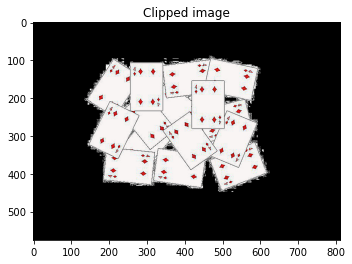

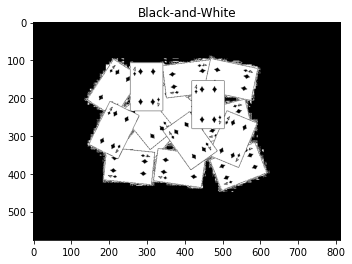

In [19]:
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv.filter2D(src, cv.CV_32F, kernel)
sharp = np.float32(src)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)

bw = cv.cvtColor(imgResult, cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

plt.imshow(imgResult); plt.title('Clipped image'); plt.show()
plt.imshow(bw, cmap='gray'); plt.title('Black-and-White'); plt.show()

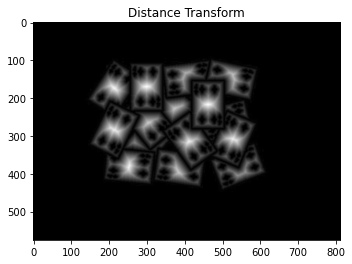

In [52]:
dist = cv.distanceTransform(bw, cv.DIST_L2, 3)

# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
plt.imshow(dist, cmap='gray'); plt.title('Distance Transform'); plt.show()

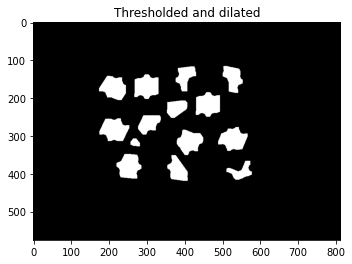

In [51]:

_, dist = cv.threshold(dist, 0.4, 1.0, cv.THRESH_BINARY)

# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv.dilate(dist, kernel1)

plt.imshow(dist, cmap='gray'); plt.title('Thresholded and dilated'); plt.show()

dist_8u = dist.astype('uint8')

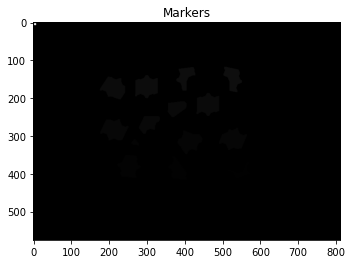

In [48]:
# Find total markers
contours, _ = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)    
# Draw the background marker
cv.circle(markers, (5,5), 3, (255,255,255), -1)
plt.imshow(markers, cmap='gray'); plt.title('Markers'); plt.show()

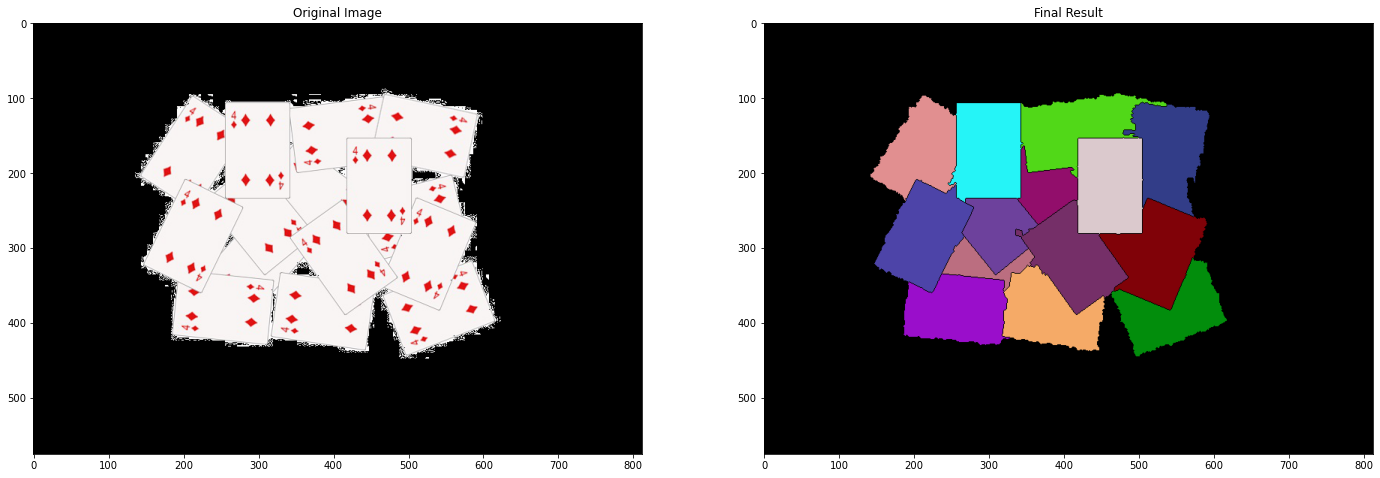

In [49]:
# Perform the watershed algorithm
cv.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]

plt.figure(figsize=(24,12))
plt.subplot(1,2,1); plt.imshow(src); plt.title('Original Image')
plt.subplot(1,2,2); plt.imshow(dst); plt.title('Final Result'); plt.show()
